In [1]:
# Toolbox
import tools as tools

# Standard imports 
import numpy as np
import pandas as pd
import geopandas as gpd

# Latex tables
from stargazer.stargazer import Stargazer

# Plotting 
import matplotlib.pyplot as plt 

plt.style.use('seaborn-whitegrid')
%matplotlib inline

import statsmodels.formula.api as smf
import statsmodels.api as sm
from toolz import curry

plt.rcParams['figure.figsize'] = 11, 6 # set default size of plots

# Filter warnings 
pd.options.mode.chained_assignment = None
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

C:\Users\JBH\AppData\Local\Temp\ipykernel_26392\2862705803.py:7: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd
C:\Users\JBH\AppData\Local\Temp\ipykernel_26392\2862705803.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped 

**Table of contents**<a id='toc0_'></a>    
- [Data analysis](#toc1_)    
  - [Read web-scraped data](#toc1_1_)    
  - [Convert GPS-coordinates to POINTS](#toc1_2_)    
  - [Read in municipal/regional shape files](#toc1_3_)    
  - [Assign house to old municipality](#toc1_4_)    
  - [Merge landtaxes, house price index, bbr evaluations & lot size info](#toc1_5_)    
  - [Make map of tax changes](#toc1_6_)    
  - [How many areas changed land taxes and how many did not?](#toc1_7_)    
- [Econometrics](#toc2_)    
  - [Research strategy](#toc2_1_)    
    - [Conditional quantiles (I), fixed effects equal across quantiles](#toc2_1_1_)    
      - [Result (I): Indications of heterogenous effects?](#toc2_1_1_1_)    
      - [2005-2007 year coefficients](#toc2_1_1_2_)    
    - [Conditional quantiles, within-quantile fixed effects (II)](#toc2_1_2_)    
      - [2000-2006 & 2008 year-coefficients](#toc2_1_2_1_)    
      - [Result (II): Evidence of capitalization effects?](#toc2_1_2_2_)    
- [Robustness stuff](#toc3_)    
  - [OLS-FE](#toc3_1_)    
  - [Cond. quantiles](#toc3_2_)    
- [Misc](#toc4_)    
  - [Do we have parallel pre-trends for the OLS-FE estimate?](#toc4_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

Header (state non-commercial/academic intentions) for scraper

In [2]:
header = {'name' : 'Jørgen Baun Høst',          'email' : 'pjz633@econ.ku.dk',
          'intention': 'Scrape Boliga for academic purposes'}

# <a id='toc1_'></a>[Data analysis](#toc0_)
## <a id='toc1_1_'></a>[Read web-scraped data](#toc0_)

In [3]:
df=pd.read_parquet('data/boliga.pq')
df=df.sort_values('soldDate')
df['guid']=df['guid'].str.lower()
df['price_1000']=df['price']/1000
df=df[(df['year']>=2000) & (df['year']<=2010)]
df=df.reset_index(drop=True)
df['time_6m']=pd.PeriodIndex(df['soldDate'], freq='2Q')
df['time_m']=pd.PeriodIndex(df['soldDate'], freq='M')
df


,estateId,address,zipCode,price,soldDate,propertyType,saleType,sqmPrice,rooms,size,...,groupKey,canGetVR,bfEnr,year,month,week,time_q,price_1000,time_6m,time_m
0,0,Højkolvej 36,8210,1495000,2000-01-01 23:00:00+00:00,1,Alm. Salg,8542.8570,4.0,175,...,NaN,True,4220221,2000,1,5,2000Q1,1495.000,2000Q1,2000-01
1,0,Borthigsgade 26,6000,564680,2000-01-01 23:00:00+00:00,1,Alm. Salg,4826.3247,3.0,117,...,NaN,True,5679177,2000,1,5,2000Q1,564.680,2000Q1,2000-01
2,0,Horsekilden 17,4000,1251000,2000-01-01 23:00:00+00:00,1,Alm. Salg,10170.7310,4.0,123,...,NaN,True,1304154,2000,1,5,2000Q1,1251.000,2000Q1,2000-01
3,0,Skovbakkevej 99,8800,370000,2000-01-01 23:00:00+00:00,1,Alm. Salg,2356.6880,6.0,157,...,NaN,True,8459754,2000,1,5,2000Q1,370.000,2000Q1,2000-01
4,0,Præstebakken 15,2610,1458444,2000-01-01 23:00:00+00:00,1,Alm. Salg,7596.0625,7.0,192,...,NaN,True,2041293,2000,1,5,2000Q1,1458.444,2000Q1,2000-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502012,0,Lillevangsvej 6,4174,1500000,2010-12-31 23:00:00+00:00,1,Alm. Salg,12000.0000,5.0,125,...,NaN,True,2496794,2010,12,4,2010Q4,1500.000,2010Q4,2010-12
502013,0,Ludvig Holsteins Alle 17,2750,1675000,2010-12-31 23:00:00+00:00,1,Alm. Salg,10029.9400,5.0,147,...,NaN,True,2108731,2010,12,4,2010Q4,1675.000,2010Q4,2010-12
502014,0,Østerbyvej 9,9990,3000000,2010-12-31 23:00:00+00:00,1,Alm. Salg,15873.0160,6.0,189,...,NaN,True,5530559,2010,12,4,2010Q4,3000.000,2010Q4,2010-12
502015,526788,Engparken 37,6740,1125000,2010-12-31 23:00:00+00:00,1,Alm. Salg,10416.6670,4.0,108,...,NaN,True,5047083,2010,12,4,2010Q4,1125.000,2010Q4,2010-12


## <a id='toc1_2_'></a>[Convert GPS-coordinates to POINTS](#toc0_)

In [4]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
gdf.head()

,estateId,address,zipCode,price,soldDate,propertyType,saleType,sqmPrice,rooms,size,...,canGetVR,bfEnr,year,month,week,time_q,price_1000,time_6m,time_m,geometry
0,0,Højkolvej 36,8210,1495000,2000-01-01 23:00:00+00:00,1,Alm. Salg,8542.8570,4.0,175,...,True,4220221,2000,1,5,2000Q1,1495.000,2000Q1,2000-01,POINT (10.16913 56.16901)
1,0,Borthigsgade 26,6000,564680,2000-01-01 23:00:00+00:00,1,Alm. Salg,4826.3247,3.0,117,...,True,5679177,2000,1,5,2000Q1,564.680,2000Q1,2000-01,POINT (9.47292 55.48263)
2,0,Horsekilden 17,4000,1251000,2000-01-01 23:00:00+00:00,1,Alm. Salg,10170.7310,4.0,123,...,True,1304154,2000,1,5,2000Q1,1251.000,2000Q1,2000-01,POINT (12.02684 55.63139)
3,0,Skovbakkevej 99,8800,370000,2000-01-01 23:00:00+00:00,1,Alm. Salg,2356.6880,6.0,157,...,True,8459754,2000,1,5,2000Q1,370.000,2000Q1,2000-01,POINT (9.43825 56.47037)
4,0,Præstebakken 15,2610,1458444,2000-01-01 23:00:00+00:00,1,Alm. Salg,7596.0625,7.0,192,...,True,2041293,2000,1,5,2000Q1,1458.444,2000Q1,2000-01,POINT (12.46182 55.67929)


## <a id='toc1_3_'></a>[Read in municipal/regional shape files](#toc0_)

In [5]:
kommune_2006 = gpd.read_file('data/kommune_2006.shp')
kommune_2006.head()

,objectid,navn,enhedid,fra,til,enhedtype,art,SHAPE_Leng,SHAPE_Area,geometry
0,24842.0,Københavns Kommune,120727.0,2002-12-31,2006-12-31,64.0,Kommune,154225.005507,9.028113e+07,"MULTIPOLYGON Z (((12.73424 55.70328 0.00000, 1..."
1,24843.0,Frederiksberg Kommune,120728.0,1970-04-01,2006-12-31,64.0,Kommune,13520.324243,8.709197e+06,"POLYGON Z ((12.53736 55.69661 0.00000, 12.5370..."
2,46149.0,Birkerød Kommune,120748.0,1974-01-04,2006-12-31,64.0,Kommune,35777.227097,3.366869e+07,"POLYGON Z ((12.45040 55.81888 0.00000, 12.4473..."
3,46165.0,Græsted-Gilleleje Kommune,120753.0,1972-10-01,2006-12-31,64.0,Kommune,67562.933801,1.341441e+08,"POLYGON Z ((12.39490 56.03226 0.00000, 12.3952..."
4,46190.0,Jægerspris Kommune,120759.0,1975-01-01,2006-12-31,64.0,Kommune,84485.880031,9.514108e+07,"MULTIPOLYGON Z (((11.92257 55.90000 0.00000, 1..."


In [6]:
regioner=gpd.read_file('data/regioner.shp')
regioner

,objectid,navn,enhedid,fra,til,enhedtype,art,SHAPE_Leng,SHAPE_Area,geometry
0,105612.0,Region Hovedstaden,118711.0,2007-01-01,9999-12-31,66.0,Region,7.371152e+05,2.563160e+09,"MULTIPOLYGON Z (((15.19733 55.31846 0.00000, 1..."
1,105615.0,Region Sjælland,118712.0,2011-11-27,9999-12-31,66.0,Region,2.196684e+06,7.216493e+09,"MULTIPOLYGON Z (((12.54857 54.95316 0.00000, 1..."
2,105616.0,Region Syddanmark,118713.0,2007-01-01,9999-12-31,66.0,Region,2.436420e+06,1.209603e+10,"MULTIPOLYGON Z (((10.68129 54.72772 0.00000, 1..."
3,105620.0,Region Midtjylland,118715.0,2011-01-01,9999-12-31,66.0,Region,2.564054e+06,1.299856e+10,"MULTIPOLYGON Z (((11.67150 56.73861 0.00000, 1..."
4,105617.0,Region Nordjylland,118714.0,2007-01-01,9999-12-31,66.0,Region,1.697705e+06,7.870127e+09,"MULTIPOLYGON Z (((10.98412 57.21880 0.00000, 1..."


## <a id='toc1_4_'></a>[Assign house to old municipality](#toc0_)

In [7]:
gdf_merge=gpd.sjoin(gdf, kommune_2006, predicate='within')
cols_to_drop=['index_right',
 'objectid',
 'navn',
 'enhedid',
 'fra',
 'til',
 'enhedtype',
 'art',
 'SHAPE_Leng',
 'SHAPE_Area']
gdf_merge['kommune_old']=gdf_merge['navn']
gdf_merge=gdf_merge.drop(columns=cols_to_drop)
gdf_merge=gpd.sjoin(gdf_merge, regioner, predicate='within')
gdf_merge['region']=gdf_merge['navn']
gdf_merge=gdf_merge.drop(columns=cols_to_drop)
gdf_merge.head()

C:\Users\JBH\AppData\Local\Temp\ipykernel_26392\118371585.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  gdf_merge=gpd.sjoin(gdf, kommune_2006, predicate='within')
C:\Users\JBH\AppData\Local\Temp\ipykernel_26392\118371585.py:14: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  gdf_merge=gpd.sjoin(gdf_merge, regioner, predicate='within')


,estateId,address,zipCode,price,soldDate,propertyType,saleType,sqmPrice,rooms,size,...,year,month,week,time_q,price_1000,time_6m,time_m,geometry,kommune_old,region
0,0,Højkolvej 36,8210,1495000,2000-01-01 23:00:00+00:00,1,Alm. Salg,8542.8570,4.0,175,...,2000,1,5,2000Q1,1495.00,2000Q1,2000-01,POINT (10.16913 56.16901),Århus Kommune,Region Midtjylland
23,0,Byløkken 32,8240,1887740,2000-01-01 23:00:00+00:00,1,Alm. Salg,10372.1980,6.0,182,...,2000,1,5,2000Q1,1887.74,2000Q1,2000-01,POINT (10.22040 56.20569),Århus Kommune,Region Midtjylland
32,0,Gertrud Rasks Vej 2,8200,1576500,2000-01-02 23:00:00+00:00,1,Alm. Salg,9219.2980,6.0,171,...,2000,1,6,2000Q1,1576.50,2000Q1,2000-01,POINT (10.21504 56.17655),Århus Kommune,Region Midtjylland
39,0,Bjørnshøjvej 2K,8380,875000,2000-01-02 23:00:00+00:00,1,Alm. Salg,7812.5000,4.0,112,...,2000,1,6,2000Q1,875.00,2000Q1,2000-01,POINT (10.15009 56.25355),Århus Kommune,Region Midtjylland
42,0,Skæring Havvej 31,8250,1566000,2000-01-02 23:00:00+00:00,1,Alm. Salg,7492.8228,6.0,209,...,2000,1,6,2000Q1,1566.00,2000Q1,2000-01,POINT (10.30097 56.23074),Århus Kommune,Region Midtjylland


In [8]:
house_price_index = pd.read_excel('data/house_price_index.xlsx')
house_price_index['time_q']=pd.PeriodIndex(house_price_index['time_q'], freq='Q')
land_taxes = pd.read_excel('data/kmn_grundskyldspromille.xlsx', sheet_name='Sheet2')
property_evals_01=pd.read_parquet('data/bbr_eval2001.pq')
property_evals_07=pd.read_parquet('data/bbr_eval2007.pq')
lot_sizes = pd.read_parquet('data/bbr_lotsize.pq')

## <a id='toc1_5_'></a>[Merge landtaxes, house price index, bbr evaluations & lot size info](#toc0_)

In [9]:
df_merged = pd.DataFrame(gdf_merge)
df_merged_index = pd.merge(df_merged, house_price_index, left_on=['time_q', 'region'], right_on=['time_q', 'region'])
df_merged_index = pd.merge(df_merged_index, land_taxes, left_on=['kommune_old'], right_on=['kommune_old'])
df_merged_index = pd.merge(df_merged_index, property_evals_01, left_on=['guid'], right_on=['guid'])
df_merged_index=df_merged_index.drop(columns=['eval_year'])
df_merged_index = pd.merge(df_merged_index, property_evals_07, left_on=['guid'], right_on=['guid'])
df_merged_index=df_merged_index.drop(columns=['eval_year'])
df_merged_index = pd.merge(df_merged_index, lot_sizes, left_on=['guid'], right_on=['guid'])
df_merged_index

,estateId,address,zipCode,price,soldDate,propertyType,saleType,sqmPrice,rooms,size,...,kommune_grundskyld2007,delta_tax,delta_tax_service,eval_prop_2001,eval_land_2001,eval2001_last_changed,eval_prop_2007,eval_land_2007,eval2007_last_changed,lot_size
0,0,Højkolvej 36,8210,1495000,2000-01-01 23:00:00+00:00,1,Alm. Salg,8542.8570,4.0,175,...,"24,58",-0.02,0.10,1600000,393500,2001-01-01,3000000,787000,2007-10-01,774
1,0,Højkolvej 36,8210,2770000,2006-05-23 22:00:00+00:00,1,Alm. Salg,15828.5710,4.0,175,...,"24,58",-0.02,0.10,1600000,393500,2001-01-01,3000000,787000,2007-10-01,774
2,0,Byløkken 32,8240,1887740,2000-01-01 23:00:00+00:00,1,Alm. Salg,10372.1980,6.0,182,...,"24,58",-0.02,0.10,1700000,364700,2001-01-01,3550000,1296800,2007-10-01,821
3,0,Gertrud Rasks Vej 2,8200,1576500,2000-01-02 23:00:00+00:00,1,Alm. Salg,9219.2980,6.0,171,...,"24,58",-0.02,0.10,1800000,466900,2001-01-01,3850000,1127000,2007-10-01,810
4,0,Bjørnshøjvej 2K,8380,875000,2000-01-02 23:00:00+00:00,1,Alm. Salg,7812.5000,4.0,112,...,"24,58",-0.02,0.10,870000,252600,2001-01-01,1800000,631500,2007-10-01,884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482047,508367,Danzigmannvej 3,9940,1075000,2010-07-29 22:00:00+00:00,1,Alm. Salg,10858.5860,5.0,99,...,"33,04",-0.96,-0.77,340000,62700,2001-01-01,510000,150700,2007-10-01,2500
482048,0,"Vesterø Havnegade 12, 1",9940,1500000,2010-07-31 22:00:00+00:00,1,Alm. Salg,15625.0000,3.0,96,...,"33,04",-0.96,-0.77,360000,69500,2001-01-01,900000,249400,2007-10-01,910
482049,459987,Byrumvej 45,9940,295000,2010-08-26 22:00:00+00:00,1,Alm. Salg,2107.1428,6.0,98,...,"33,04",-0.96,-0.77,320000,45100,2001-01-01,490000,117300,2007-10-01,1005
482050,435189,Gammel Østerbyvej 20,9940,498000,2010-09-01 22:00:00+00:00,1,Alm. Salg,3458.3333,4.0,144,...,"33,04",-0.96,-0.77,490000,41800,2001-01-01,770000,108600,2007-10-01,870


Keeping non-zero observations

In [10]:
df_merged_index=df_merged_index[df_merged_index['lot_size']!=0]
df_merged_index=df_merged_index[df_merged_index['eval_prop_2001']!=0]
df_merged_index=df_merged_index[df_merged_index['eval_prop_2007']!=0]
df_merged_index

,estateId,address,zipCode,price,soldDate,propertyType,saleType,sqmPrice,rooms,size,...,kommune_grundskyld2007,delta_tax,delta_tax_service,eval_prop_2001,eval_land_2001,eval2001_last_changed,eval_prop_2007,eval_land_2007,eval2007_last_changed,lot_size
0,0,Højkolvej 36,8210,1495000,2000-01-01 23:00:00+00:00,1,Alm. Salg,8542.8570,4.0,175,...,"24,58",-0.02,0.10,1600000,393500,2001-01-01,3000000,787000,2007-10-01,774
1,0,Højkolvej 36,8210,2770000,2006-05-23 22:00:00+00:00,1,Alm. Salg,15828.5710,4.0,175,...,"24,58",-0.02,0.10,1600000,393500,2001-01-01,3000000,787000,2007-10-01,774
2,0,Byløkken 32,8240,1887740,2000-01-01 23:00:00+00:00,1,Alm. Salg,10372.1980,6.0,182,...,"24,58",-0.02,0.10,1700000,364700,2001-01-01,3550000,1296800,2007-10-01,821
3,0,Gertrud Rasks Vej 2,8200,1576500,2000-01-02 23:00:00+00:00,1,Alm. Salg,9219.2980,6.0,171,...,"24,58",-0.02,0.10,1800000,466900,2001-01-01,3850000,1127000,2007-10-01,810
4,0,Bjørnshøjvej 2K,8380,875000,2000-01-02 23:00:00+00:00,1,Alm. Salg,7812.5000,4.0,112,...,"24,58",-0.02,0.10,870000,252600,2001-01-01,1800000,631500,2007-10-01,884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482047,508367,Danzigmannvej 3,9940,1075000,2010-07-29 22:00:00+00:00,1,Alm. Salg,10858.5860,5.0,99,...,"33,04",-0.96,-0.77,340000,62700,2001-01-01,510000,150700,2007-10-01,2500
482048,0,"Vesterø Havnegade 12, 1",9940,1500000,2010-07-31 22:00:00+00:00,1,Alm. Salg,15625.0000,3.0,96,...,"33,04",-0.96,-0.77,360000,69500,2001-01-01,900000,249400,2007-10-01,910
482049,459987,Byrumvej 45,9940,295000,2010-08-26 22:00:00+00:00,1,Alm. Salg,2107.1428,6.0,98,...,"33,04",-0.96,-0.77,320000,45100,2001-01-01,490000,117300,2007-10-01,1005
482050,435189,Gammel Østerbyvej 20,9940,498000,2010-09-01 22:00:00+00:00,1,Alm. Salg,3458.3333,4.0,144,...,"33,04",-0.96,-0.77,490000,41800,2001-01-01,770000,108600,2007-10-01,870


## <a id='toc1_6_'></a>[Make map of tax changes](#toc0_)
Merge land tax info

In [11]:
kommune_2006=kommune_2006.rename(columns={'navn': 'kommune_old'})

In [12]:
kommune_2006=kommune_2006.merge(land_taxes, on='kommune_old')

In [13]:
from matplotlib import colors
mycmap = colors.ListedColormap(['midnightblue','mediumblue','blue','cyan','red','orangered','darkred'])
norm = colors.Normalize(kommune_2006.delta_tax.min(), kommune_2006.delta_tax.max())

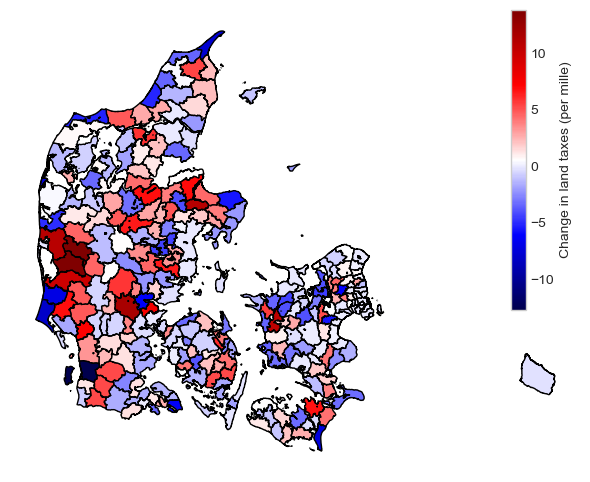

In [14]:
fig, ax = plt.subplots(1, 1)
kommune_2006.plot(column='delta_tax',
           ax=ax,
           cmap='seismic',
           norm=norm,
           legend=True,
           legend_kwds={'label': "Change in land taxes (per mille)",
                        'orientation': "vertical",
                        "shrink":.65,
                        'anchor': (-1, 1)},
            edgecolor='k')
ax.set_axis_off()   
fig.savefig('figs/fig_map_taxes.pdf', bbox_inches = "tight")

Adding important variables

In [15]:
df_merged_index['real_price']=df_merged_index['price']/df_merged_index['house_price_index']
df_merged_index['real_sqmPrice']=df_merged_index['sqmPrice']/df_merged_index['house_price_index']
df_merged_index['ln_prop_value']=np.log(df_merged_index['eval_prop_2001'])
df_merged_index['ln_price']=np.log(df_merged_index['price'])
df_merged_index['ln_real_price']=np.log(df_merged_index['real_price'])
df_merged_index['delta_tax_eff']=(df_merged_index['delta_tax']*df_merged_index['eval_land_2007']/df_merged_index['eval_prop_2007'])
df_merged_index['delta_tax_service']

0         0.10
1         0.10
2         0.10
3         0.10
4         0.10
          ... 
482047   -0.77
482048   -0.77
482049   -0.77
482050   -0.77
482051   -0.77
Name: delta_tax_service, Length: 480638, dtype: float64

Categorize data by changes to land taxes

In [16]:
def land_tax_change07(value):
    if value > 0:
        return "Higher"
    elif value < 0:
        return "Lower"
    else:
        return "Unchanged"
df_merged_index['tax_change_reform'] = df_merged_index.apply(lambda row: land_tax_change07(row['delta_tax']), axis = 1)
df_merged_index['tax_change_reform']=df_merged_index['tax_change_reform'].astype('category')

## <a id='toc1_7_'></a>[How many areas changed land taxes and how many did not?](#toc0_)

In [17]:
df_merged_index.groupby('tax_change_reform')['kommune_old'].nunique()

tax_change_reform
Higher       132
Lower        110
Unchanged     24
Name: kommune_old, dtype: int64

In [18]:
df_merged_index.groupby('tax_change_reform')[['kommune_old', 'delta_tax']].max()

,kommune_old,delta_tax
tax_change_reform,,
Higher,Ørbæk Kommune,13.86
Lower,Ærø Kommune,-0.02
Unchanged,Værløse Kommune,0.00


In [19]:
df_merged_index.groupby('tax_change_reform')[['kommune_old', 'delta_tax']].max()

,kommune_old,delta_tax
tax_change_reform,,
Higher,Ørbæk Kommune,13.86
Lower,Ærø Kommune,-0.02
Unchanged,Værløse Kommune,0.00


In [20]:
df_merged_index.groupby('tax_change_reform')[['kommune_old', 'delta_tax']].min()

,kommune_old,delta_tax
tax_change_reform,,
Higher,Allerød Kommune,0.02
Lower,Augustenborg Kommune,-12.76
Unchanged,Brøndbyøster-Brøndbyvester Kommune,0.00


In [21]:
df_merged_index[df_merged_index['year']>=2007].groupby('tax_change_reform')[['kommune_old', 'delta_tax_eff']].mean()

C:\Users\JBH\AppData\Local\Temp\ipykernel_26392\2888431242.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_merged_index[df_merged_index['year']>=2007].groupby('tax_change_reform')[['kommune_old', 'delta_tax_eff']].mean()


,delta_tax_eff
tax_change_reform,
Higher,0.670389
Lower,-0.453174
Unchanged,0.000000


In [22]:
df_merged_index[df_merged_index['year']>=2007].groupby('tax_change_reform')[['kommune_old', 'delta_tax_eff']].std()

C:\Users\JBH\AppData\Local\Temp\ipykernel_26392\491435750.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_merged_index[df_merged_index['year']>=2007].groupby('tax_change_reform')[['kommune_old', 'delta_tax_eff']].std()


,delta_tax_eff
tax_change_reform,
Higher,0.734330
Lower,0.524529
Unchanged,0.000000


In [23]:
df_merged_index.groupby('tax_change_reform')[['kommune_old', 'eval_prop_2007']].mean()/1000

C:\Users\JBH\AppData\Local\Temp\ipykernel_26392\4118881633.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_merged_index.groupby('tax_change_reform')[['kommune_old', 'eval_prop_2007']].mean()/1000


,eval_prop_2007
tax_change_reform,
Higher,1794.302509
Lower,1812.015257
Unchanged,3380.962513


In [24]:
df_merged_index.groupby('tax_change_reform')[['kommune_old', 'eval_prop_2007']].std()/1000

C:\Users\JBH\AppData\Local\Temp\ipykernel_26392\4272510388.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_merged_index.groupby('tax_change_reform')[['kommune_old', 'eval_prop_2007']].std()/1000


,eval_prop_2007
tax_change_reform,
Higher,3394.361410
Lower,2816.223155
Unchanged,2962.725886


In [25]:
# Get house prices sold in year 2003 & 2007

df_2003 = df_merged_index[df_merged_index['year']==2003]
df_2007 = df_merged_index[df_merged_index['year']==2007]
df1=df_2003.groupby('tax_change_reform')[['kommune_old', 'price']].mean()/1000
df1=df1['price'].drop('Unchanged', axis=0)
df2=df_2007.groupby('tax_change_reform')[['kommune_old', 'price']].mean()/1000
df2=df2['price'].drop('Unchanged', axis=0)

# Make dif-n-dif table
tab_house_prices=pd.DataFrame([df1, df2]).T
tab_house_prices.columns=['2003', '2007']
tab_house_prices['Difference']=tab_house_prices['2007']-tab_house_prices['2003']
tab_house_prices=tab_house_prices.T
tab_house_prices['Difference']=tab_house_prices['Higher']-tab_house_prices['Lower']
tab_house_prices=tab_house_prices.T
tab_house_prices=tab_house_prices.round(2)
tab_house_prices=pd.DataFrame(tab_house_prices.to_dict())
tab_house_prices

C:\Users\JBH\AppData\Local\Temp\ipykernel_26392\3125616903.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df1=df_2003.groupby('tax_change_reform')[['kommune_old', 'price']].mean()/1000
C:\Users\JBH\AppData\Local\Temp\ipykernel_26392\3125616903.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2=df_2007.groupby('tax_change_reform')[['kommune_old', 'price']].mean()/1000


,2003,2007,Difference
Higher,1134.22,1668.35,534.13
Lower,1122.99,1743.78,620.80
Difference,11.23,-75.43,-86.67


In [26]:
# Get house prices sold in year 2003 & 2007

df_2003 = df_merged_index[df_merged_index['year']==2003]
df_2007 = df_merged_index[df_merged_index['year']==2007]
df1=df_2003.groupby('tax_change_reform')[['kommune_old', 'price']].mean()/1000
df1=df1['price'].drop('Unchanged', axis=0)
df2=df_2007.groupby('tax_change_reform')[['kommune_old', 'price']].mean()/1000
df2=df2['price'].drop('Unchanged', axis=0)

# Make dif-n-dif table
tab_house_prices=pd.DataFrame([df1, df2]).T
tab_house_prices.columns=['2003', '2007']
tab_house_prices['Difference']=tab_house_prices['2007']-tab_house_prices['2003']
tab_house_prices=tab_house_prices.T
tab_house_prices['Difference']=tab_house_prices['Higher']-tab_house_prices['Lower']
tab_house_prices=tab_house_prices.T
tab_house_prices=tab_house_prices.round(2)
tab_house_prices=pd.DataFrame(tab_house_prices.to_dict())
tab_house_prices

C:\Users\JBH\AppData\Local\Temp\ipykernel_26392\3125616903.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df1=df_2003.groupby('tax_change_reform')[['kommune_old', 'price']].mean()/1000
C:\Users\JBH\AppData\Local\Temp\ipykernel_26392\3125616903.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2=df_2007.groupby('tax_change_reform')[['kommune_old', 'price']].mean()/1000


,2003,2007,Difference
Higher,1134.22,1668.35,534.13
Lower,1122.99,1743.78,620.80
Difference,11.23,-75.43,-86.67


In [27]:
# Get house prices sold in year 2003 & 2007

df_2003 = df_merged_index[df_merged_index['year']==2003]
df_2007 = df_merged_index[df_merged_index['year']==2007]
df1=df_2003.groupby('tax_change_reform')[['kommune_old', 'price']].quantile(.25)/1000
df1=df1['price'].drop('Unchanged', axis=0)
df2=df_2007.groupby('tax_change_reform')[['kommune_old', 'price']].quantile(.25)/1000
df2=df2['price'].drop('Unchanged', axis=0)

# Make dif-n-dif table
tab_house_prices_q25=pd.DataFrame([df1, df2]).T
tab_house_prices_q25.columns=['2003', '2007']
tab_house_prices_q25['Difference']=tab_house_prices_q25['2007']-tab_house_prices_q25['2003']
tab_house_prices_q25=tab_house_prices_q25.T
tab_house_prices_q25['Difference']=tab_house_prices_q25['Higher']-tab_house_prices_q25['Lower']
tab_house_prices_q25=tab_house_prices_q25.T
tab_house_prices_q25=tab_house_prices_q25.round(2)
tab_house_prices_q25=pd.DataFrame(tab_house_prices_q25.to_dict())
tab_house_prices_q25

C:\Users\JBH\AppData\Local\Temp\ipykernel_26392\2220859285.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df1=df_2003.groupby('tax_change_reform')[['kommune_old', 'price']].quantile(.25)/1000
C:\Users\JBH\AppData\Local\Temp\ipykernel_26392\2220859285.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2=df_2007.groupby('tax_change_reform')[['kommune_old', 'price']].quantile(.25)/1000


,2003,2007,Difference
Higher,614.0,850.0,236.0
Lower,650.0,950.0,300.0
Difference,-36.0,-100.0,-64.0


In [28]:
# Get house prices sold in year 2003 & 2007

df_2003 = df_merged_index[df_merged_index['year']==2003]
df_2007 = df_merged_index[df_merged_index['year']==2007]
df1=df_2003.groupby('tax_change_reform')[['kommune_old', 'price']].quantile(.75)/1000
df1=df1['price'].drop('Unchanged', axis=0)
df2=df_2007.groupby('tax_change_reform')[['kommune_old', 'price']].quantile(.75)/1000
df2=df2['price'].drop('Unchanged', axis=0)

# Make dif-n-dif table
tab_house_prices_q75=pd.DataFrame([df1, df2]).T
tab_house_prices_q75.columns=['2003', '2007']
tab_house_prices_q75['Difference']=tab_house_prices_q75['2007']-tab_house_prices_q75['2003']
tab_house_prices_q75=tab_house_prices_q75.T
tab_house_prices_q75['Difference']=tab_house_prices_q75['Higher']-tab_house_prices_q75['Lower']
tab_house_prices_q75=tab_house_prices_q75.T
tab_house_prices_q75=tab_house_prices_q75.round(2)
tab_house_prices_q75=pd.DataFrame(tab_house_prices_q75.to_dict())
tab_house_prices_q75

C:\Users\JBH\AppData\Local\Temp\ipykernel_26392\2309939048.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df1=df_2003.groupby('tax_change_reform')[['kommune_old', 'price']].quantile(.75)/1000
C:\Users\JBH\AppData\Local\Temp\ipykernel_26392\2309939048.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2=df_2007.groupby('tax_change_reform')[['kommune_old', 'price']].quantile(.75)/1000


,2003,2007,Difference
Higher,1438.8,1965.0,526.2
Lower,1335.0,2075.0,740.0
Difference,103.8,-110.0,-213.8


In [29]:
file_name = "tabs/dif_n_dif_tab.tex" #Include directory path if needed
tex_file = open(file_name, "w" ) #This will overwrite an existing file
tex_file.write(tab_house_prices.to_latex())
tex_file.close()

C:\Users\JBH\AppData\Local\Temp\ipykernel_26392\3239160736.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tex_file.write(tab_house_prices.to_latex())


In [30]:
file_name = "tabs/dif_n_dif_tab_q25.tex" #Include directory path if needed
tex_file = open(file_name, "w" ) #This will overwrite an existing file
tex_file.write(tab_house_prices_q25.to_latex() )
tex_file.close()
file_name = "tabs/dif_n_dif_tab_q75.tex" #Include directory path if needed
tex_file = open(file_name, "w" ) #This will overwrite an existing file
tex_file.write(tab_house_prices_q75.to_latex() )
tex_file.close()

C:\Users\JBH\AppData\Local\Temp\ipykernel_26392\4170236646.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tex_file.write(tab_house_prices_q25.to_latex() )
C:\Users\JBH\AppData\Local\Temp\ipykernel_26392\4170236646.py:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tex_file.write(tab_house_prices_q75.to_latex() )


In [31]:
df_merged_index[df_merged_index['year']>=2007]['delta_tax_eff'].mean()

0.060088384318130746

In [32]:
df_merged_index[df_merged_index['year']>=2007]['delta_tax_eff'].std()

0.7946022781952236

In [33]:
df_merged_index=df_merged_index[df_merged_index['tax_change_reform']!="Unchanged"]

C:\Users\JBH\AppData\Local\Temp\ipykernel_26392\1102246799.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temp_agg=df_merged_index.groupby(['year', 'tax_change_reform']).mean()\


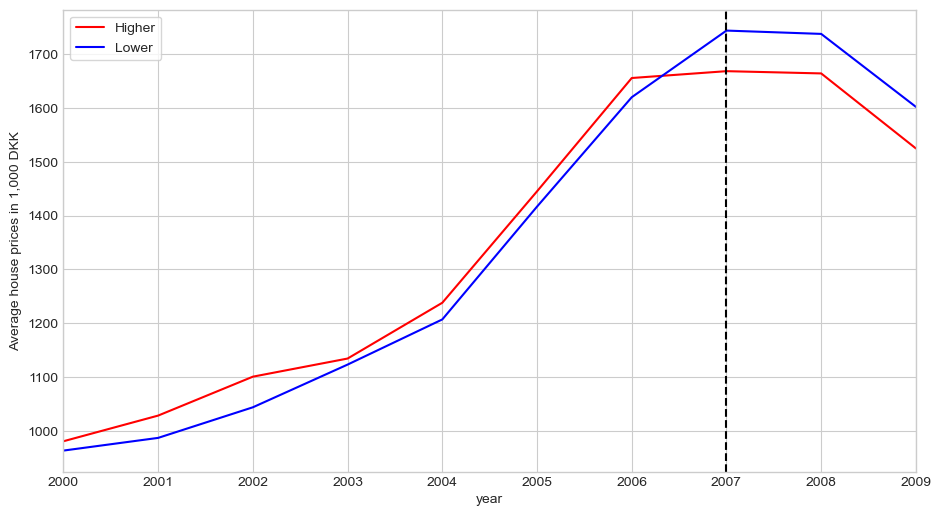

In [34]:
temp_agg=df_merged_index.groupby(['year', 'tax_change_reform']).mean()\
                        .unstack()['price_1000'][['Higher', 'Lower']]
plot=temp_agg.plot(color=['r', 'b'])
plot.axvline(x=2007,color='k', linestyle='--')
plot.set_xlim(2000, 2009)
plot.legend(frameon=True)
plot.set_xticks(np.arange(df_merged_index['year'].min(), df_merged_index['year'].max(), 1))
plt.ylabel('Average house prices in 1,000 DKK')

plt.savefig('figs/fig_house_price_trends.pdf', bbox_inches='tight')

In [35]:
df_merged_index=df_merged_index[df_merged_index['year']<=2008]
df_merged_index = df_merged_index.reset_index(drop=True)

In [36]:
stata_out = df_merged_index[['guid','ln_price', 'ln_real_price', 'kommune_old', 'year', 'ln_prop_value', 'delta_tax_eff', 'delta_tax_service']]
stata_out['kommune_old_id']=stata_out.groupby('kommune_old').ngroup()
stata_out['id']=stata_out.groupby('guid').ngroup()
stata_out.to_stata('data/house.dta')

# <a id='toc2_'></a>[Econometrics](#toc0_)
Function to demean

In [37]:
@curry
def demean(df, col_to_demean):
    return df.assign(**{col_to_demean: (df[col_to_demean]
                                        - df.groupby("kommune_old")[col_to_demean].transform("mean"))
                                        - df.groupby("year")[col_to_demean].transform("mean")})

Create variables that capture (potentially gradual) effect of changes to effect land value taxes following the 2007 reform

In [38]:
years = [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008]


for year in years:
    var_name = f'year{year}_delta_tax_eff'
    df_merged_index[var_name]=(df_merged_index['year']==year).astype(int)*df_merged_index['delta_tax_eff']
    var_name2 = f'year{year}_delta_tax_service'
    df_merged_index[var_name2]=(df_merged_index['year']==year).astype(int)*df_merged_index['delta_tax_service']

## <a id='toc2_1_'></a>[Research strategy](#toc0_)

### <a id='toc2_1_1_'></a>[Conditional quantiles (I), fixed effects equal across quantiles](#toc0_)

$$
\begin{equation}
    \ln{P}_{h,a,t}(\tau)=\beta_{0}(\tau)+\alpha_a+\gamma_t+\sum_{t=2005}^{2008}\phi_{t}(\tau) \Delta ELTR_{h,a}+\beta_{1}(\tau)\ln{V}_{01,h,a}+\epsilon_{h,a,t}(\tau)
\end{equation}
$$

Things to note:
- Fixed effects equal across quantiles (mostly for computational simplicity).
- Interested in the $\phi_{2007}(\tau)$ coefficient(s)

In [39]:
# formula_quant = f"""ln_real_price ~ year2005_delta_tax_eff + year2006_delta_tax_eff + year2007_delta_tax_eff + year2008_delta_tax_eff + ln_prop_value"""

# mod_quantile_fe_across = smf.quantreg(formula_quant,
#               data=df_merged_index)

**OLS-FE**

Let's compare with an OLS estimate. Same specification with fixed effects, though now of course we are modelling a conditional mean. 

Standard errors are clustered at the individual house level ("robust" standard errors).

In [40]:
formula = f"""ln_real_price ~ year2005_delta_tax_eff + year2006_delta_tax_eff + year2007_delta_tax_eff + year2008_delta_tax_eff + ln_prop_value"""

mod_ols_fe = smf.ols(formula,
              data=df_merged_index
              .pipe(demean(col_to_demean="ln_real_price"))
              .pipe(demean(col_to_demean="year2005_delta_tax_eff"))
              .pipe(demean(col_to_demean="year2006_delta_tax_eff"))
              .pipe(demean(col_to_demean="year2007_delta_tax_eff"))
              .pipe(demean(col_to_demean="year2008_delta_tax_eff"))
              .pipe(demean(col_to_demean="ln_prop_value")))
res_ols_fe=mod_ols_fe.fit(vcov='robust', fe=True)
price_preds = res_ols_fe.predict()

In [41]:
res_ols_fe.params

Intercept                -4.833897
year2005_delta_tax_eff   -0.014224
year2006_delta_tax_eff   -0.025398
year2007_delta_tax_eff   -0.030197
year2008_delta_tax_eff   -0.015461
ln_prop_value             0.679670
dtype: float64

In [42]:
df_merged_index.groupby("kommune_old")['year2005_delta_tax_eff'].transform("mean")

0        -0.000831
1        -0.000831
2        -0.000831
3        -0.000831
4        -0.000831
            ...   
374890   -0.033093
374891   -0.033093
374892   -0.033093
374893   -0.033093
374894   -0.033093
Name: year2005_delta_tax_eff, Length: 374895, dtype: float64

In [43]:
n = df_merged_index.shape[0]

# Nx1 matrix
Y_bar = tools.demean_columns(df_merged_index, ['ln_real_price']).values

cols_to_demean=['year2005_delta_tax_eff', 'year2006_delta_tax_eff', 'year2007_delta_tax_eff', 'year2008_delta_tax_eff', 'ln_prop_value']
X_demean=tools.demean_columns(df_merged_index, cols_to_demean).values
x0 = np.ones(n).reshape(-1,1)

# NxK
X_bar=np.hstack((x0, X_demean))

# Kx1 matrix
theta_hat = res_ols_fe.params.values.reshape(-1,1)

# "Estimate" the fixed effect
fixx=Y_bar-X_bar@theta_hat

In [44]:
df_merged_index['fixx']=fixx.flatten()
df_merged_index['ln_real_price_hat']=df_merged_index['ln_real_price']-df_merged_index['fixx']

In [45]:
formula_quant = f"""ln_real_price_hat ~ year2005_delta_tax_eff + year2006_delta_tax_eff + year2007_delta_tax_eff + year2008_delta_tax_eff + ln_prop_value"""

mod_quantile_fe_across = smf.quantreg(formula_quant,
              data=df_merged_index)

In [46]:
def fit_model(q, sig_level=0.05, params_to_keep=None, model=None):
    result_quantile = model.fit(q=q, vcov='robust')
    if type(params_to_keep)!=list:
        result_quantile = model.fit(q=q, vcov='robust')
        res_fit = [q, result_quantile.params["year2007_delta_tax_eff"]] + result_quantile.conf_int(alpha=sig_level).loc[
        "year2007_delta_tax_eff"
    ].tolist()
    else:
        coefs_=result_quantile.params[params_to_keep]
        conf_int=result_quantile.conf_int(alpha=sig_level).loc[params_to_keep]
        res_fit = pd.DataFrame(coefs_, columns=['coefs'])
        res_fit[['lb', 'ub']]=conf_int
        res_fit['q']=q
    return res_fit

In [47]:
quantiles = np.arange(0.1, 0.9+0.1, 0.1)

models_fe_across = [fit_model(q=q, model=mod_quantile_fe_across, params_to_keep=["year2005_delta_tax_eff", "year2006_delta_tax_eff", "year2007_delta_tax_eff"]) for q in quantiles]
models_fe_across=pd.concat(models_fe_across)\
                    .reset_index()\
                    .rename(columns={'index': 'varname'})

In [48]:
ols_fe_ci = res_ols_fe.conf_int(alpha=0.05).loc['year2007_delta_tax_eff'].to_list()
ols_fe_dict=dict(param=res_ols_fe.params['year2007_delta_tax_eff'], lb=ols_fe_ci[0], ub=ols_fe_ci[1])

#### <a id='toc2_1_1_1_'></a>[Result (I): Indications of heterogenous effects?](#toc0_)

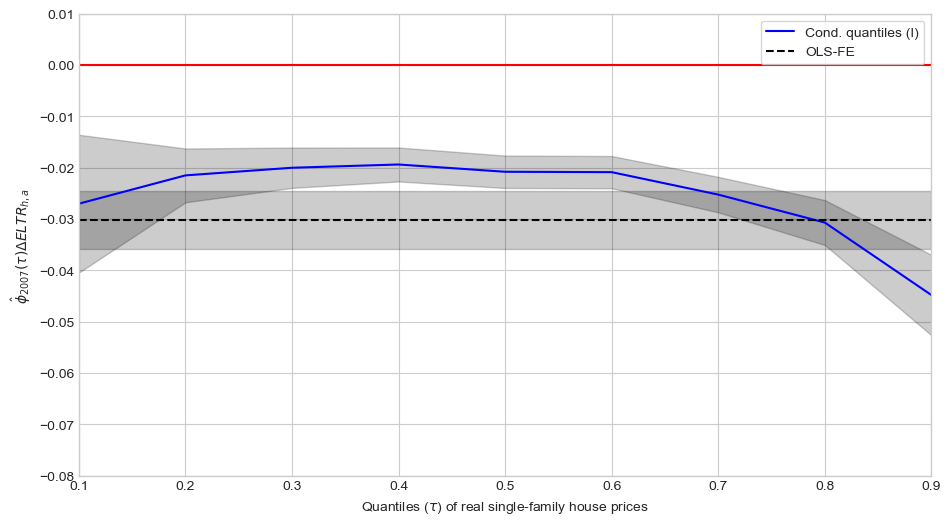

In [49]:
year = 2007
var_name = f'year{year}_delta_tax_eff'
df_sub_set=models_fe_across[models_fe_across['varname']==var_name]

param_name = r'$\hat{{\phi}}_{{{year}}}(\tau) \Delta E L T R_{{h,a}}$'.format(year=year)
n = models_fe_across.shape[0]

plt.plot(df_sub_set.q, df_sub_set.coefs, color="blue", label="Cond. quantiles (I)")
plt.fill_between(df_sub_set.q, df_sub_set.lb, df_sub_set.ub, alpha=0.2, color="black")
plt.plot(models_fe_across.q, [ols_fe_dict["param"]] * n, color="black", linestyle='--',label="OLS-FE")
plt.fill_between(models_fe_across.q, ols_fe_dict["lb"], ols_fe_dict["ub"], alpha=0.2, color="black")
plt.ylabel(param_name)
plt.xlabel(r"Quantiles ($\tau$) of real single-family house prices")
plt.axhline(0, color='red')
plt.xlim(0.1, 0.9)
plt.ylim(-0.08, 0.01)
plt.legend(frameon=True)
plt.savefig('figs/fig_quant_reg_v_ols.pdf', bbox_inches='tight')
plt.show()

#### <a id='toc2_1_1_2_'></a>[2005-2007 year coefficients](#toc0_)

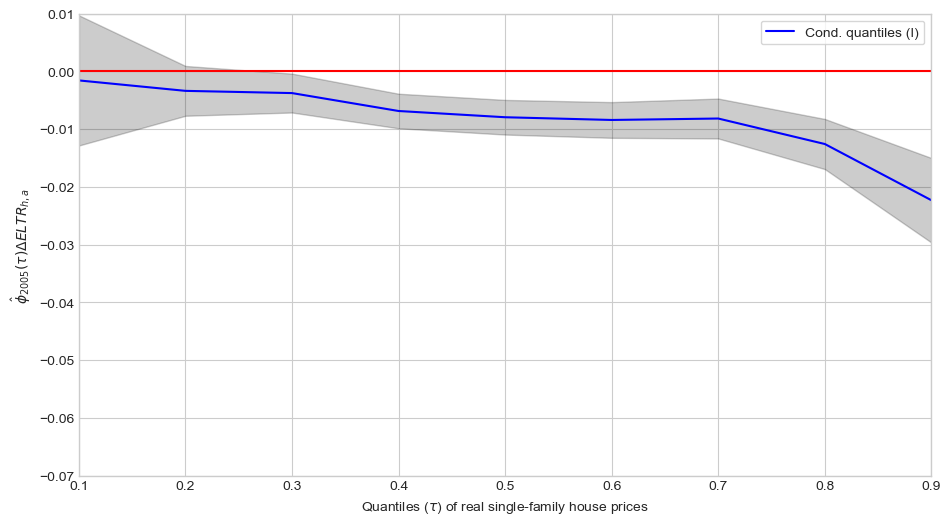

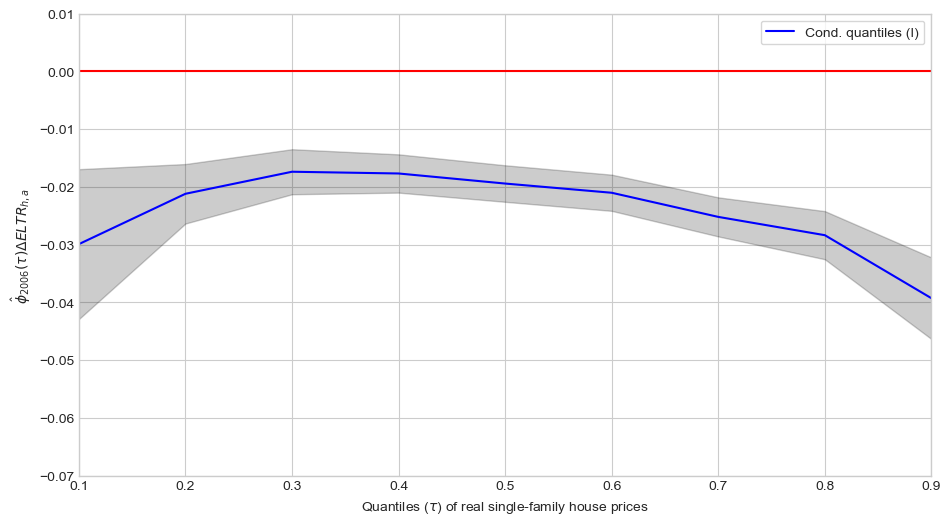

In [50]:
years = [2005, 2006]

for year in years:
    var_name = f'year{year}_delta_tax_eff'
    df_sub_set=models_fe_across[models_fe_across['varname']==var_name]

    param_name = r'$\hat{{\phi}}_{{{year}}}(\tau) \Delta E L T R_{{h,a}}$'.format(year=year)
    plot_name = f'quant_reg_v_ols_{year}'

    plt.plot(df_sub_set.q, df_sub_set.coefs, color="blue", label="Cond. quantiles (I)")
    plt.fill_between(df_sub_set.q, df_sub_set.lb, df_sub_set.ub, alpha=0.2, color="black")
    plt.ylabel(param_name)
    plt.xlabel(r"Quantiles ($\tau$) of real single-family house prices")
    plt.axhline(0, color='red')
    plt.xlim(0.1, 0.9)
    plt.ylim(-0.07, 0.01)
    plt.legend(frameon=True)
    plt.savefig(f'figs/fig_{plot_name}.pdf', bbox_inches='tight')
    plt.show()

### <a id='toc2_1_2_'></a>[Conditional quantiles, within-quantile fixed effects (II)](#toc0_)
NB! Requires Stata 17 or higher, see [pystata](https://www.stata.com/python/pystata18/notebook/Quick%20Start0.html)

$$
\begin{align}
    \ln{P}_{h,a,t}(\boldsymbol{\tau})&=\beta_{0}(\boldsymbol{\tau})+\alpha_a(\boldsymbol{\tau})+\gamma_t(\boldsymbol{\tau})+\sum_{t=2005}^{2008}\phi_{t}(\boldsymbol{\tau}) \Delta ELTR_{h,a}+\beta_{1}(\boldsymbol{\tau})\ln{V}_{01,h,a}+\epsilon_{h,a,t}(\boldsymbol{\tau})
    \\
    \ln{P}_{h,a,t}(\boldsymbol{\tau})&=\beta_{0}(\boldsymbol{\tau})+\alpha_a(\boldsymbol{\tau})+\gamma_t(\boldsymbol{\tau})+\sum_{t=2000}^{2008}\phi_{t}(\boldsymbol{\tau}) \Delta ELTR_{h,a}+\beta_{1}(\boldsymbol{\tau})\ln{V}_{01,h,a}+\epsilon_{h,a,t}(\boldsymbol{\tau})
\end{align}
$$

Normalize $\phi_{2004}(\boldsymbol{\tau})=0$ in spec (2) for identification.

NB! Standard errors are clustered at the individual house level / 'robust' standard errors.

In [51]:
import stata_setup

path_to_stata = "C:/Program Files/Stata17"
stata_version = 'mp'

stata_setup.config(path_to_stata, stata_version)


  ___  ____  ____  ____  ____ ®
 /__    /   ____/   /   ____/      17.0
___/   /   /___/   /   /___/       MP—Parallel Edition

 Statistics and Data Science       Copyright 1985-2021 StataCorp LLC
                                   StataCorp
                                   4905 Lakeway Drive
                                   College Station, Texas 77845 USA
                                   800-STATA-PC        https://www.stata.com
                                   979-696-4600        stata@stata.com

Stata license: Unlimited-user 2-core network, expiring 31 Aug 2023
Serial number: 501709399182
  Licensed to: Jørgen Baun Høst
               University of Copenhagen

Notes:
      1. Unicode is supported; see help unicode_advice.
      2. More than 2 billion observations are allowed; see help obs_advice.
      3. Maximum number of variables is set to 5,000 but can be increased;
          see help set_maxvar.


In [52]:
%%stata

do "4_qreg.do"


. 
. do "4_qreg.do"

. use "data\house.dta", clear

. 
. forvalues i=2000/2008 {
  2.         gen year`i'= 1 if year == `i'
  3.         replace year`i'=0 if year != `i'
  4.         gen year`i'_delta_tax_eff = year`i'*delta_tax_eff
  5.         gen year`i'_delta_tax_service = year`i'*delta_tax_service
  6. }
(329,861 missing values generated)
(329,861 real changes made)
(332,923 missing values generated)
(332,923 real changes made)
(333,260 missing values generated)
(333,260 real changes made)
(333,194 missing values generated)
(333,194 real changes made)
(332,910 missing values generated)
(332,910 real changes made)
(326,252 missing values generated)
(326,252 real changes made)
(332,244 missing values generated)
(332,244 real changes made)
(334,064 missing values generated)
(334,064 real changes made)
(344,452 missing values generated)
(344,452 real changes made)

. 
. forvalues i = 10(10)90 {
  2.         preserve
  3.         eststo quant_est_`i': qui mmqreg  ln_real_price year200

In [53]:
list_of_dfs = []

for quant in range(10, 90+10, 10):
    df = pd.read_stata(f'models/trend_diff/quant_est_{quant}_trend_diff_04.dta')
    list_of_dfs.append(df)

quantiles_within_fe_trend_04 = pd.concat(list_of_dfs).reset_index(drop=True) 
quantiles_within_fe_trend_04

,q,b,se,z,pvalue,ll,ul,df,crit,eform,varname
0,0.1,-0.006028,0.007959,-0.757309,4.488646e-01,-0.021628,0.009572,NaN,1.959964,0.0,2000
1,0.1,0.007299,0.007835,0.931548,3.515700e-01,-0.008058,0.022656,NaN,1.959964,0.0,2001
2,0.1,0.003776,0.008148,0.463370,6.430991e-01,-0.012194,0.019745,NaN,1.959964,0.0,2002
3,0.1,0.011159,0.007319,1.524722,1.273285e-01,-0.003185,0.025503,NaN,1.959964,0.0,2003
4,0.1,0.008314,0.007661,1.085230,2.778196e-01,-0.006702,0.023331,NaN,1.959964,0.0,2005
...,...,...,...,...,...,...,...,...,...,...,...
67,0.9,-0.017958,0.003825,-4.694527,2.672240e-06,-0.025455,-0.010461,NaN,1.959964,0.0,2003
68,0.9,-0.037569,0.003863,-9.724436,2.372159e-22,-0.045141,-0.029997,NaN,1.959964,0.0,2005
69,0.9,-0.042675,0.003968,-10.755557,5.579607e-27,-0.050451,-0.034898,NaN,1.959964,0.0,2006
70,0.9,-0.053609,0.004643,-11.545831,7.748894e-31,-0.062709,-0.044508,NaN,1.959964,0.0,2007


#### <a id='toc2_1_2_1_'></a>[2000-2006 & 2008 year-coefficients](#toc0_)

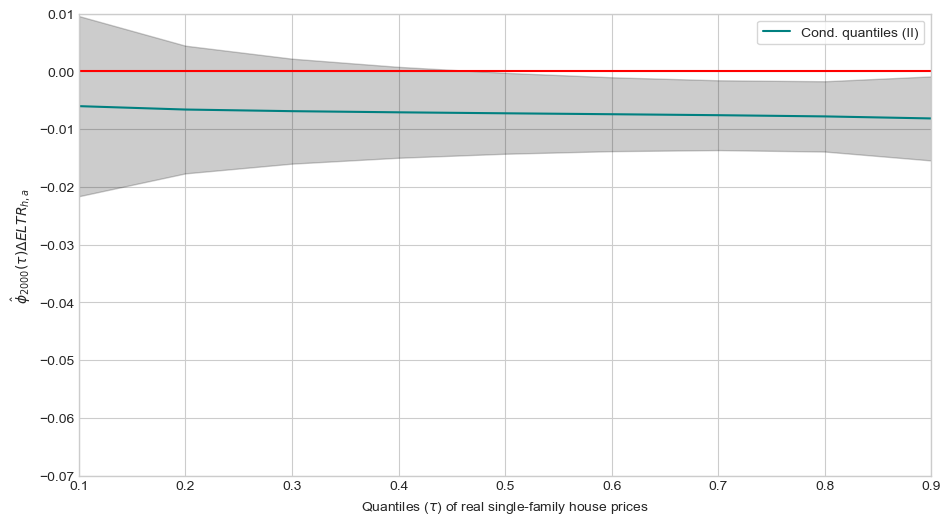

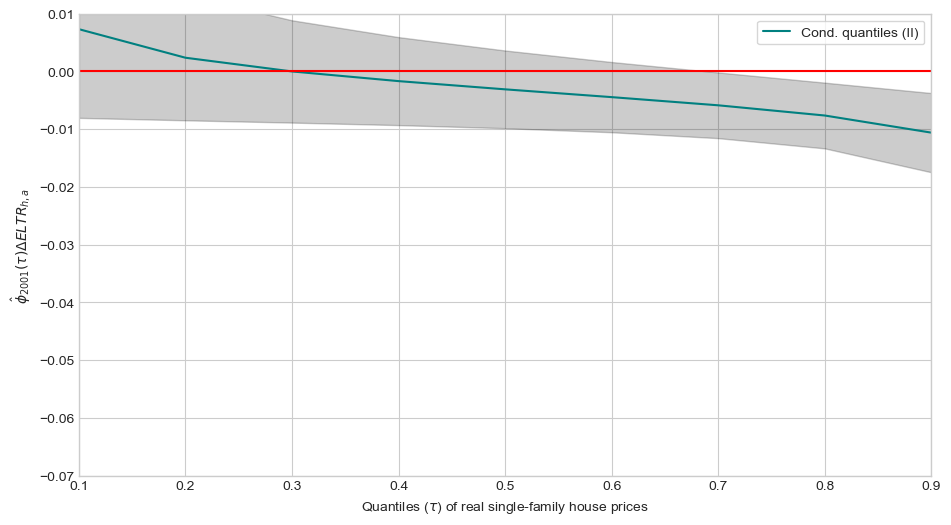

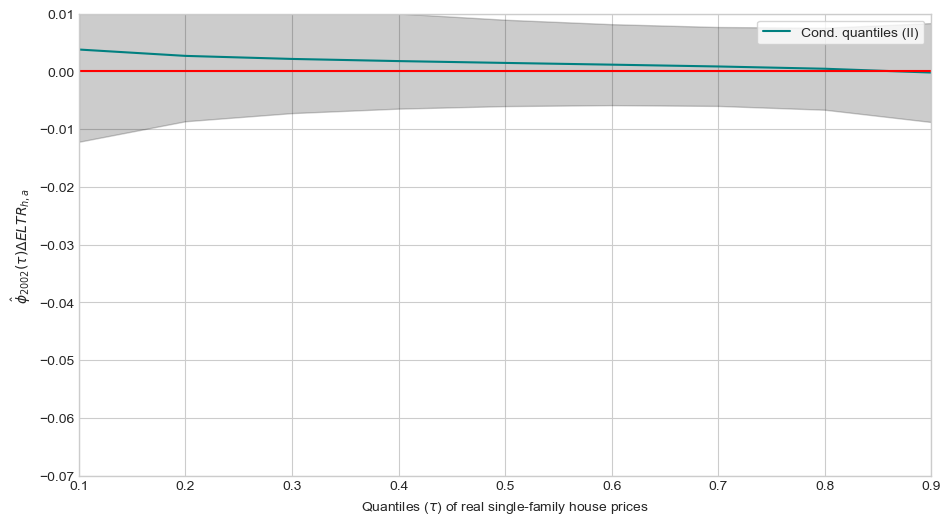

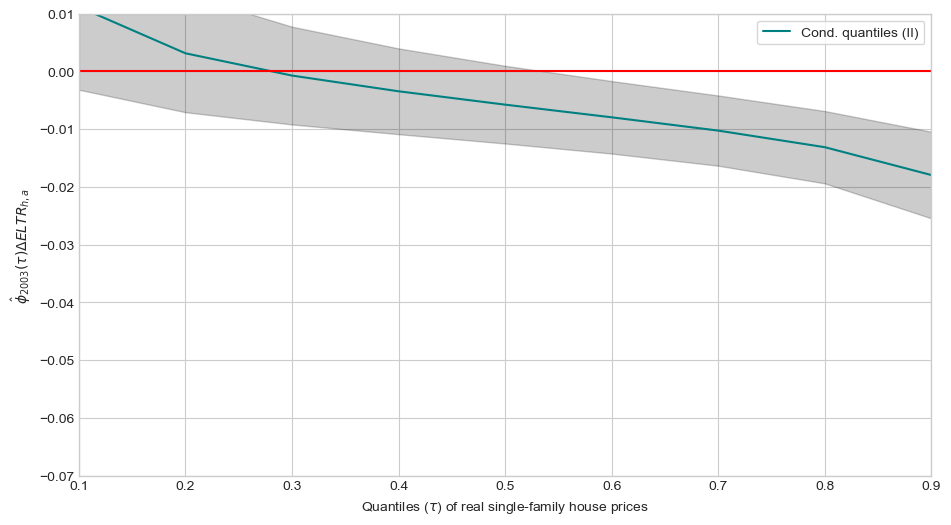

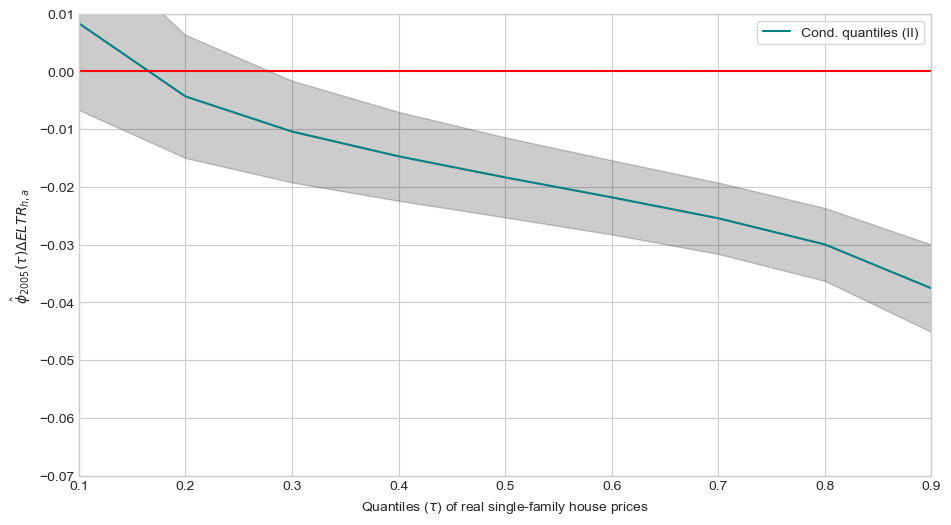

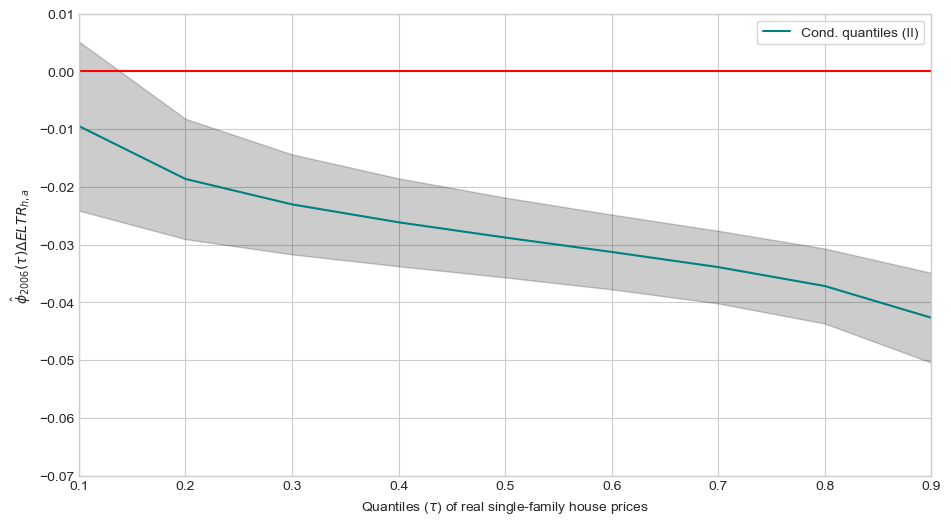

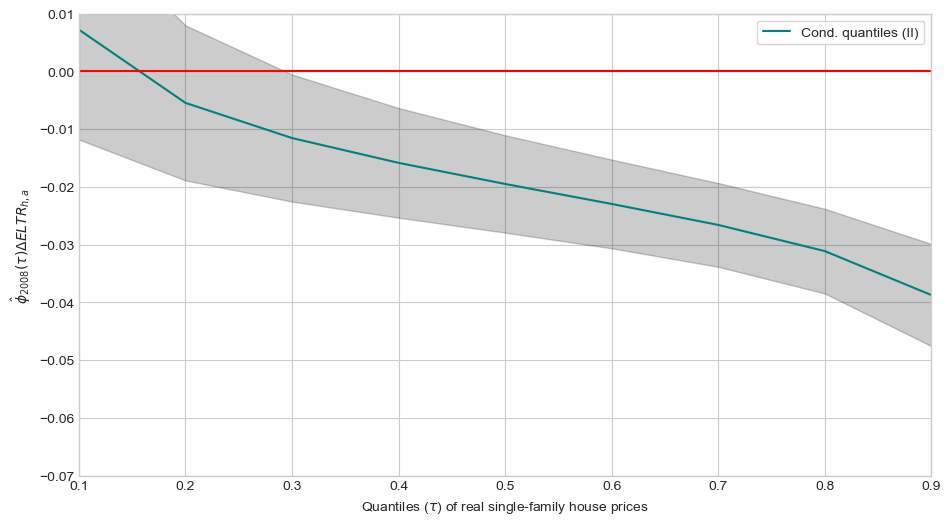

In [54]:
years = [2000, 2001, 2002, 2003, 2005, 2006, 2008]

for year in years:
    var_name = f'year{year}_delta_tax_eff'
    df_sub_set_pre_trend=quantiles_within_fe_trend_04[quantiles_within_fe_trend_04['varname']==year]

    param_name = r'$\hat{{\phi}}_{{{year}}}(\tau) \Delta E L T R_{{h,a}}$'.format(year=year)
    plot_name = f'quantiles_{year}_fe_within'

    plt.plot(df_sub_set_pre_trend.q, df_sub_set_pre_trend.b, color="teal", label="Cond. quantiles (II)")
    plt.fill_between(df_sub_set_pre_trend.q, df_sub_set_pre_trend.ll, df_sub_set_pre_trend.ul, alpha=0.2, color="black")
    plt.ylabel(param_name)
    plt.xlabel(r"Quantiles ($\tau$) of real single-family house prices")
    plt.axhline(0, color='red')
    plt.xlim(0.1, 0.9)
    plt.ylim(-0.07, 0.01)
    plt.legend(frameon=True)
    plt.savefig(f'figs/trend_diff/base_year_04/{plot_name}.pdf', bbox_inches='tight')
    plt.show()

#### <a id='toc2_1_2_2_'></a>[Result (II): Evidence of capitalization effects?](#toc0_)

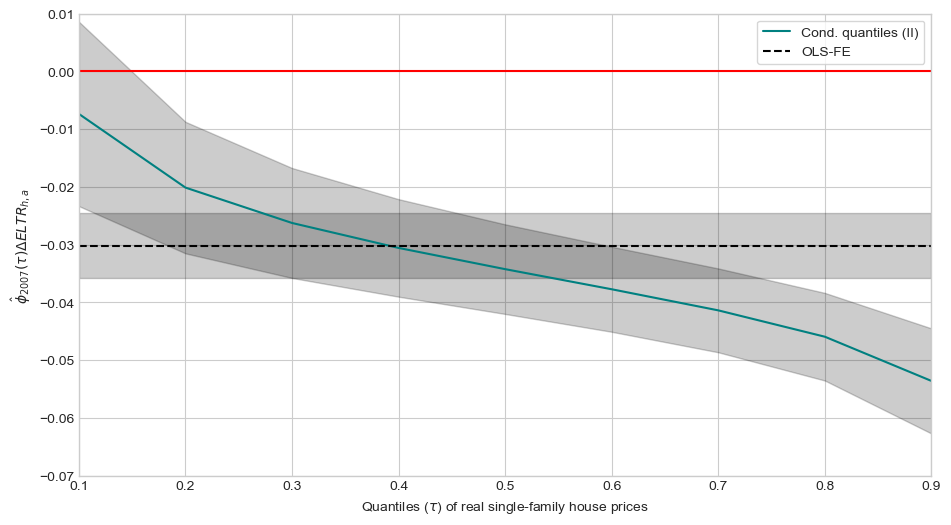

In [55]:
year=2007

var_name = f'year{year}_delta_tax_eff'
df_sub_set_pre_trend=quantiles_within_fe_trend_04[quantiles_within_fe_trend_04['varname']==year]

param_name = r'$\hat{{\phi}}_{{{year}}}(\tau) \Delta E L T R_{{h,a}}$'.format(year=year)

plt.plot(df_sub_set_pre_trend.q, df_sub_set_pre_trend.b, color="teal", label="Cond. quantiles (II)")
plt.fill_between(df_sub_set_pre_trend.q, df_sub_set_pre_trend.ll, df_sub_set_pre_trend.ul, alpha=0.2, color="black")
plt.plot(models_fe_across.q, [ols_fe_dict["param"]] * n, color="black", linestyle='--',label="OLS-FE")
plt.fill_between(models_fe_across.q, ols_fe_dict["lb"], ols_fe_dict["ub"], alpha=0.2, color="black")
plt.ylabel(param_name)
plt.xlabel(r"Quantiles ($\tau$) of real single-family house prices")
plt.axhline(0, color='red')
plt.xlim(0.1, 0.9)
plt.ylim(-0.07, 0.01)
plt.legend(frameon=True)
plt.savefig(f'figs/fig_main_quant_reg_v_ols.pdf', bbox_inches='tight')
plt.savefig(f'figs/fig_main_quant_reg_v_ols.png', bbox_inches='tight')
plt.show()

# <a id='toc3_'></a>[Robustness stuff](#toc0_)
## <a id='toc3_1_'></a>[OLS-FE](#toc0_)

In [56]:
formula_robust = f"""ln_real_price ~ year2005_delta_tax_eff + year2006_delta_tax_eff + year2007_delta_tax_eff + year2008_delta_tax_eff + ln_prop_value + year2005_delta_tax_service + year2006_delta_tax_service + year2007_delta_tax_service + year2008_delta_tax_service"""
mod_ols_fe_robust = smf.ols(formula_robust,
              data=df_merged_index
              .pipe(demean(col_to_demean="ln_real_price"))
              .pipe(demean(col_to_demean="year2005_delta_tax_eff"))
              .pipe(demean(col_to_demean="year2006_delta_tax_eff"))
              .pipe(demean(col_to_demean="year2007_delta_tax_eff"))
              .pipe(demean(col_to_demean="year2008_delta_tax_eff"))
              .pipe(demean(col_to_demean="ln_prop_value"))
              .pipe(demean(col_to_demean="year2005_delta_tax_service"))
              .pipe(demean(col_to_demean="year2006_delta_tax_service"))
              .pipe(demean(col_to_demean="year2007_delta_tax_service"))
              .pipe(demean(col_to_demean="year2008_delta_tax_service")))
res_ols_fe_robust=mod_ols_fe_robust.fit(vcov='robust', fe=True)
res_ols_fe_robust.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          ln_real_price   R-squared:                       0.366
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                 2.403e+04
Date:                Mon, 29 May 2023   Prob (F-statistic):               0.00
Time:                        15:56:04   Log-Likelihood:            -2.3925e+05
No. Observations:              374895   AIC:                         4.785e+05
Df Residuals:                  374885   BIC:                         4.786e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -4.8345      0.020   -243.019      0.000      -4.873      -4.795
year2005_delta_tax_eff        -0.0142      0.003     -5.133      0.000      -0.020      -0.009
year2006_delta_tax_eff        -0.0250      0.003     -8.636      0.000      -0.031      -0.019
year2007_delta_tax_eff        -0.0300      0.003    -10.412      0.000      -0.036      -0.024
year2008_delta_tax_eff        -0.0156      0.003     -4.746      0.000      -0.022      -0.009
ln_prop_value                  0.6797      0.001    464.816      0.000       0.677       0.683
year2005_delta_tax_service     0.0044      0.003      1.440      0.150      -0.002       0.010
year2006_delta_tax_service     0.0168      0.003      5.156      0.000       0.010       0.023
year2007_delta_tax_service     0.0090      0.003      2.683      0.007       0.002       0.016
year2008_delta_tax_service    -0.0010      0.004     -0.251      0.802      -0.008       0.007
==============================================================================
Omnibus:                   223945.738   Durbin-Watson:                   1.812
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          8299305.361
Skew:                          -2.293   Prob(JB):                         0.00
Kurtosis:                      25.589   Cond. No.                         364.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## <a id='toc3_2_'></a>[Cond. quantiles](#toc0_)

In [57]:
mod_quantile_fe_across_robust = smf.quantreg(formula_robust,
              data=df_merged_index
              .pipe(demean(col_to_demean="ln_real_price"))
              .pipe(demean(col_to_demean="year2005_delta_tax_eff"))
              .pipe(demean(col_to_demean="year2006_delta_tax_eff"))
              .pipe(demean(col_to_demean="year2007_delta_tax_eff"))
              .pipe(demean(col_to_demean="year2008_delta_tax_eff"))
              .pipe(demean(col_to_demean="ln_prop_value"))
              .pipe(demean(col_to_demean="year2005_delta_tax_service"))
              .pipe(demean(col_to_demean="year2006_delta_tax_service"))
              .pipe(demean(col_to_demean="year2007_delta_tax_service"))
              .pipe(demean(col_to_demean="year2008_delta_tax_service")))

In [58]:
quantiles = np.arange(0.1, 0.9+0.1, 0.1)


def fit_model(q, sig_level=0.05):
    result_quantile_robust = mod_quantile_fe_across_robust.fit(q=q, vcov='robust')
    return [q, result_quantile_robust.params["year2007_delta_tax_eff"]] + result_quantile_robust.conf_int(alpha=sig_level).loc[
        "year2007_delta_tax_eff"
    ].tolist()


models_fe_across_robust = [fit_model(x) for x in quantiles]
models_fe_across_robust = pd.DataFrame(models_fe_across_robust, columns=["q", "year2007_delta_tax_eff", "lb", "ub"])
models_fe_across_robust

,q,year2007_delta_tax_eff,lb,ub
0,0.1,-0.017612,-0.032248,-0.002975
1,0.2,-0.021119,-0.026718,-0.015519
2,0.3,-0.023208,-0.027004,-0.019411
3,0.4,-0.025142,-0.028449,-0.021836
4,0.5,-0.027090,-0.030226,-0.023954
5,0.6,-0.028024,-0.031254,-0.024794
6,0.7,-0.028993,-0.032725,-0.025261
7,0.8,-0.030892,-0.035759,-0.026026
8,0.9,-0.039684,-0.048408,-0.030961


In [59]:
models_fe_across_robust.to_parquet('models/quantiles_fe_across_robust.pq')

Robustness stuff to table

In [60]:
list_of_models = []
quantiles = np.arange(0.2, 0.8+0.2, 0.3)

for quantile in quantiles:
    res = mod_quantile_fe_across_robust.fit(q=quantile,vcov='robust')
    res.rsquared=None
    res.rsquared_adj=None
    list_of_models.append(res)

In [61]:
tab=Stargazer(list_of_models)
tab.rename_covariates({'ln_prop_value': r'$\ln{propvalue_{01}}$',
                       'year2005_delta_tax_eff': r'$2005\Delta ELTR$',
                       'year2006_delta_tax_eff': r'$2006\Delta ELTR$',
                       'year2007_delta_tax_eff': r'$2007\Delta ELTR$',
                       'year2008_delta_tax_eff': r'$2008\Delta ELTR$'})
tab.custom_columns(['Q20', 'Q50', 'Q80'], [1,1,1])
tab.show_degrees_of_freedom(False)
tab_notes = ['Standard errors are clustered at the individual house level ("robust" standard errors)']
tab.add_custom_notes(tab_notes)

file_name = "tabs/reg_results_robust.tex" #Include directory path if needed
tex_file = open(file_name, "w" ) #This will overwrite an existing file
tex_file.write( tab.render_latex() )
tex_file.close()
tab

In [62]:
list_of_models = []
quantiles = np.arange(0.2, 0.8+0.2, 0.3)

for quantile in quantiles:
    res = mod_quantile_fe_across.fit(q=quantile,cov_type='cluster', cov_kwds={'groups': df_merged_index['kommune_old']})
    res.rsquared=None
    res.rsquared_adj=None
    list_of_models.append(res)

res_ols_fe.rsquared=None
res_ols_fe.rsquared_adj=None

list_of_models.append(res_ols_fe)

In [63]:
tab=Stargazer(list_of_models)
tab.rename_covariates({'ln_prop_value': r'$\ln{propvalue_{01}}$',
                       'year2005_delta_tax_eff': r'$2005\Delta ELTR$',
                       'year2006_delta_tax_eff': r'$2006\Delta ELTR$',
                       'year2007_delta_tax_eff': r'$2007\Delta ELTR$',
                       'year2008_delta_tax_eff': r'$2008\Delta ELTR$'})
tab.custom_columns(['Q20', 'Q50', 'Q80', 'OLS-FE'], [1,1,1,1])
tab.show_degrees_of_freedom(False)
tab_notes = ['Standard errors are clustered at the individual house level ("robust" standard errors)']
tab.add_custom_notes(tab_notes)

file_name = "tabs/reg_results.tex" #Include directory path if needed
tex_file = open(file_name, "w" ) #This will overwrite an existing file
tex_file.write( tab.render_latex() )
tex_file.close()

tab

#### Conditional quantiles: Robustness checks w/ changes to income taxes

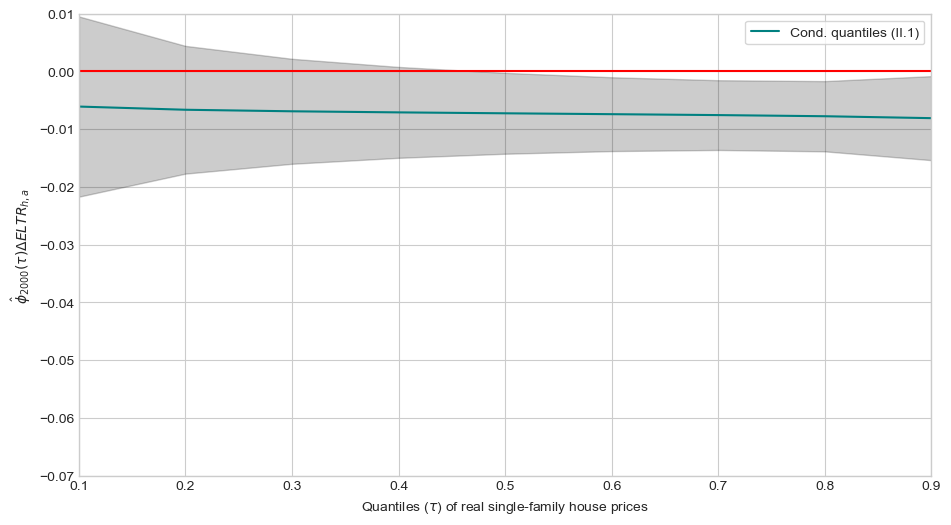

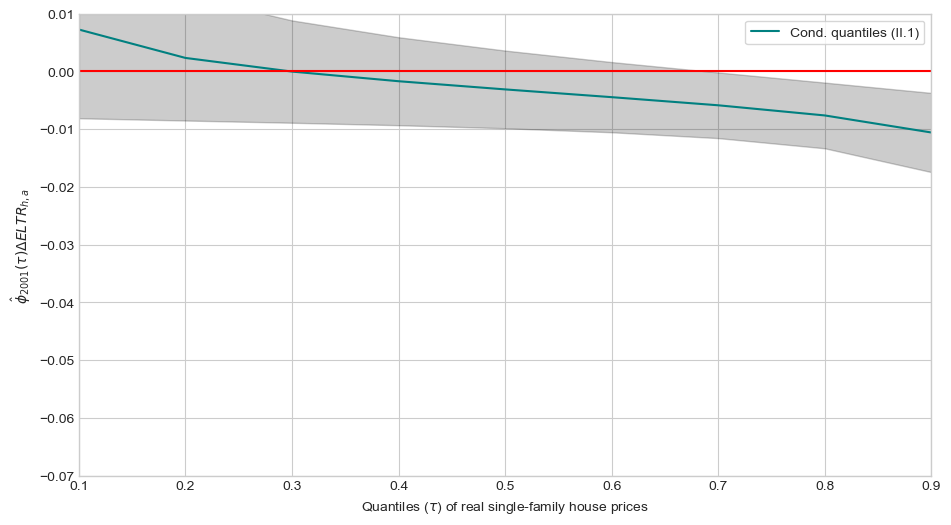

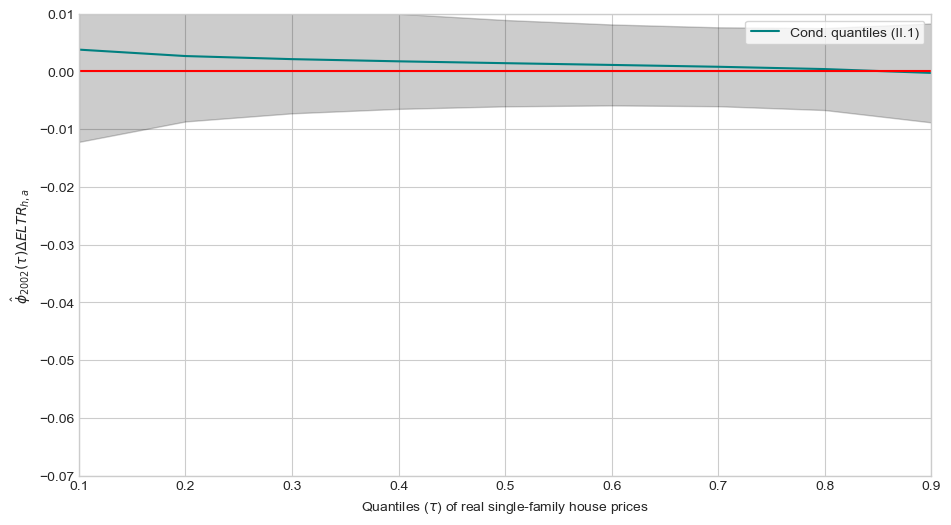

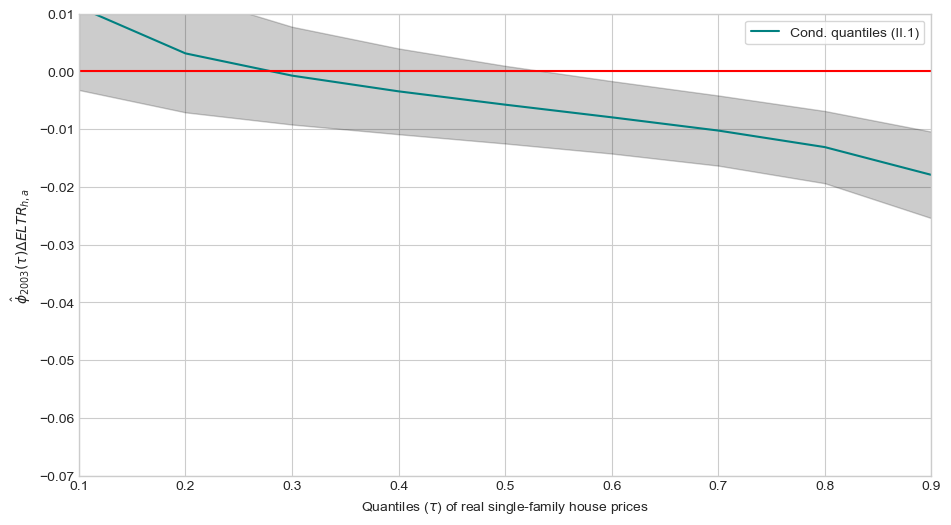

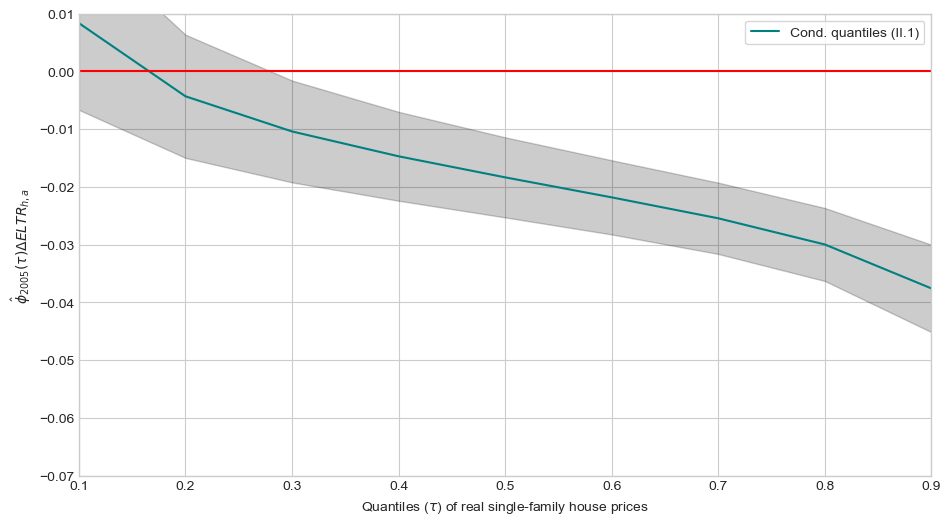

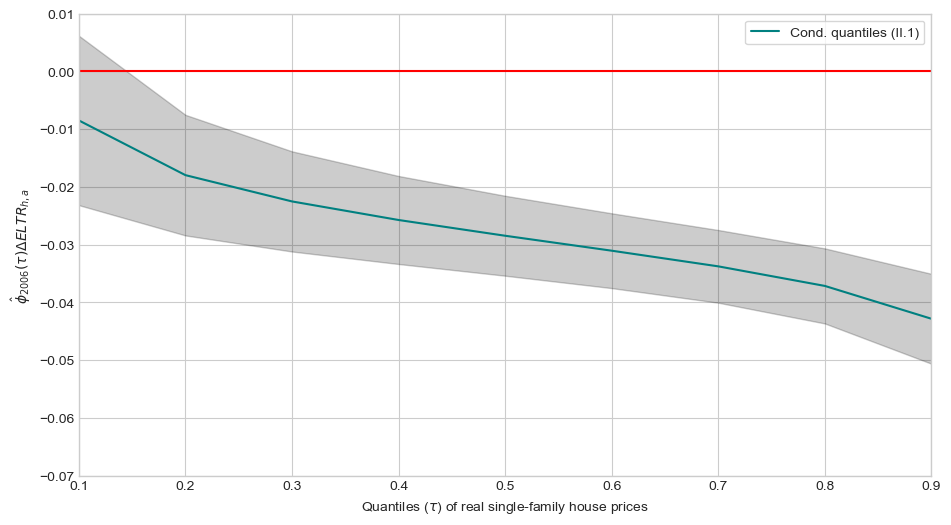

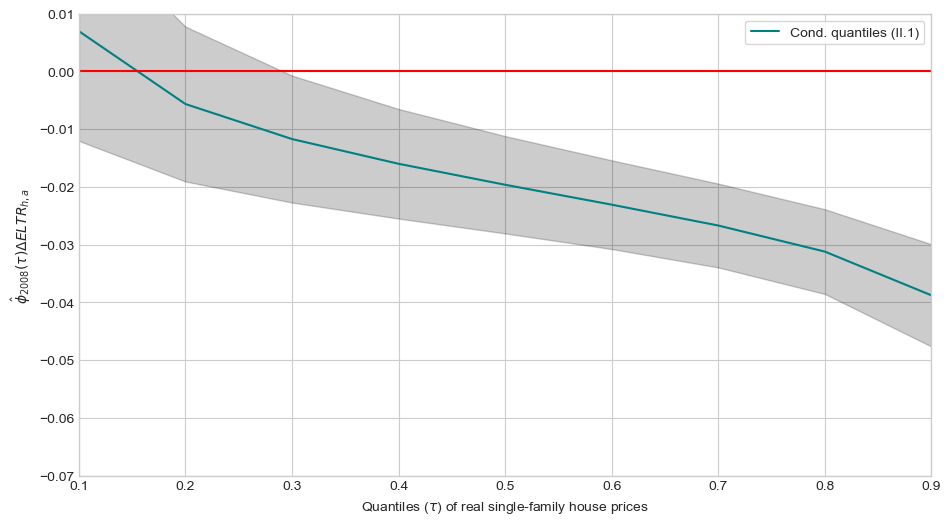

In [64]:
list_of_dfs = []

for quant in range(10, 90+10, 10):
    df = pd.read_stata(f'models/trend_diff/quant_est_{quant}_trend_diff_04_robust.dta')
    list_of_dfs.append(df)

df_fe_wiithin_robust = pd.concat(list_of_dfs).reset_index(drop=True) 
df_fe_wiithin_robust

years = [2000, 2001, 2002, 2003, 2005, 2006, 2008]

for year in years:
    var_name = f'year{year}_delta_tax_eff'
    df_sub_set_pre_trend=df_fe_wiithin_robust[df_fe_wiithin_robust['varname']==year]

    param_name = r'$\hat{{\phi}}_{{{year}}}(\tau) \Delta E L T R_{{h,a}}$'.format(year=year)
    plot_name = f'quantiles_{year}_fe_within_robust'

    plt.plot(df_sub_set_pre_trend.q, df_sub_set_pre_trend.b, color="teal", label="Cond. quantiles (II.1)")
    plt.fill_between(df_sub_set_pre_trend.q, df_sub_set_pre_trend.ll, df_sub_set_pre_trend.ul, alpha=0.2, color="black")
    plt.ylabel(param_name)
    plt.xlabel(r"Quantiles ($\tau$) of real single-family house prices")
    plt.axhline(0, color='red')
    plt.xlim(0.1, 0.9)
    plt.ylim(-0.07, 0.01)
    plt.legend(frameon=True)
    plt.savefig(f'figs/trend_diff/base_year_04/{plot_name}.pdf', bbox_inches='tight')
    plt.show()

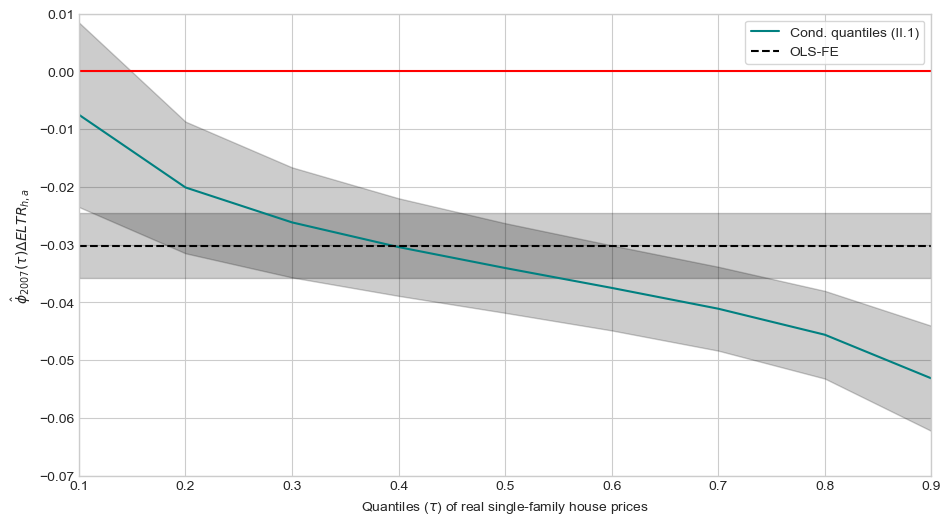

In [65]:
year=2007

var_name = f'year{year}_delta_tax_eff'
df_sub_set_pre_trend=df_fe_wiithin_robust[df_fe_wiithin_robust['varname']==year]

param_name = r'$\hat{{\phi}}_{{{year}}}(\tau) \Delta E L T R_{{h,a}}$'.format(year=year)
plot_name = f'quantiles_{year}_fe_within_robust'

plt.plot(df_sub_set_pre_trend.q, df_sub_set_pre_trend.b, color="teal", label="Cond. quantiles (II.1)")
plt.fill_between(df_sub_set_pre_trend.q, df_sub_set_pre_trend.ll, df_sub_set_pre_trend.ul, alpha=0.2, color="black")
plt.plot(models_fe_across.q, [ols_fe_dict["param"]] * n, color="black", linestyle='--',label="OLS-FE")
plt.fill_between(models_fe_across.q, ols_fe_dict["lb"], ols_fe_dict["ub"], alpha=0.2, color="black")
plt.ylabel(param_name)
plt.xlabel(r"Quantiles ($\tau$) of real single-family house prices")
plt.axhline(0, color='red')
plt.xlim(0.1, 0.9)
plt.ylim(-0.07, 0.01)
plt.legend(frameon=True)
plt.savefig(f'figs/trend_diff/base_year_04/{plot_name}_main.pdf', bbox_inches='tight')
plt.show()

# <a id='toc4_'></a>[Misc](#toc0_)
## <a id='toc4_1_'></a>[Do we have parallel pre-trends for the OLS-FE estimate?](#toc0_)
Interestingly, Høj et al (2018) did not show this...

$$
\begin{equation}
    \ln{P}_{h,a,t}=\beta_{0}+\alpha_a+\gamma_t+\sum_{t=2000}^{2008}\phi_{t} \Delta ELTR_{h,a}+\beta_{1}\ln{V}_{01,h,a}+\epsilon_{h,a,t}
\end{equation}
$$

Normalize $\phi_{2004}=0$

In [66]:
formula_trends = f"""ln_real_price ~ year2000_delta_tax_eff + year2001_delta_tax_eff+ year2002_delta_tax_eff+ year2003_delta_tax_eff+ year2005_delta_tax_eff + year2006_delta_tax_eff + year2007_delta_tax_eff + year2008_delta_tax_eff + ln_prop_value"""

mod_ols_fe_trends = smf.ols(formula_trends,
              data=df_merged_index
              .pipe(demean(col_to_demean="ln_real_price"))
              .pipe(demean(col_to_demean="year2000_delta_tax_eff"))
              .pipe(demean(col_to_demean="year2001_delta_tax_eff"))
              .pipe(demean(col_to_demean="year2002_delta_tax_eff"))
              .pipe(demean(col_to_demean="year2003_delta_tax_eff"))
              .pipe(demean(col_to_demean="year2005_delta_tax_eff"))
              .pipe(demean(col_to_demean="year2006_delta_tax_eff"))
              .pipe(demean(col_to_demean="year2007_delta_tax_eff"))
              .pipe(demean(col_to_demean="year2008_delta_tax_eff"))
              .pipe(demean(col_to_demean="ln_prop_value")))
res_ols_fe_trends=mod_ols_fe_trends.fit(vcov='robust', fe=True)
Stargazer([res_ols_fe_trends])